In [65]:
import numpy as np
np.random.seed(19)

In [66]:
import pylab as pl
%matplotlib inline

In [67]:
pl.rcParams['savefig.transparent'] = False
pl.rcParams['figure.dpi'] = 300
pl.rcParams['legend.fontsize'] = 5

# Results of the elections

In [70]:
# Ordine Nazionale Biologi
onb = np.r_[[1620, 1605, 1593, 1579, 1570, 1558, 1554, 1550, 1534, 908, 870 ,845,
           839, 837, 831, 813, 807, 807, 797, 790, 784, 783, 770, 751, 748, 725, 679,
           77, 74, 72, 65, 64, 63, 63, 59, 28, 21, 20, 16, 16, 14, 12, 9]]

In [71]:
# Consiglio Nazionale Biologi
cnb = np.r_[[1635, 1584, 1581, 1565, 1560, 1555, 1547, 1541, 1534, 1532, 1510, 1494, 1492, 1440, 1171, 1057, 865, 837, 823,
             812, 812, 811, 809, 807, 805, 803, 800, 796, 794, 788, 788, 785, 783, 783, 775, 773, 772, 768, 751, 747, 746,
             746, 738, 80, 77, 76, 69, 67, 20, 8]]

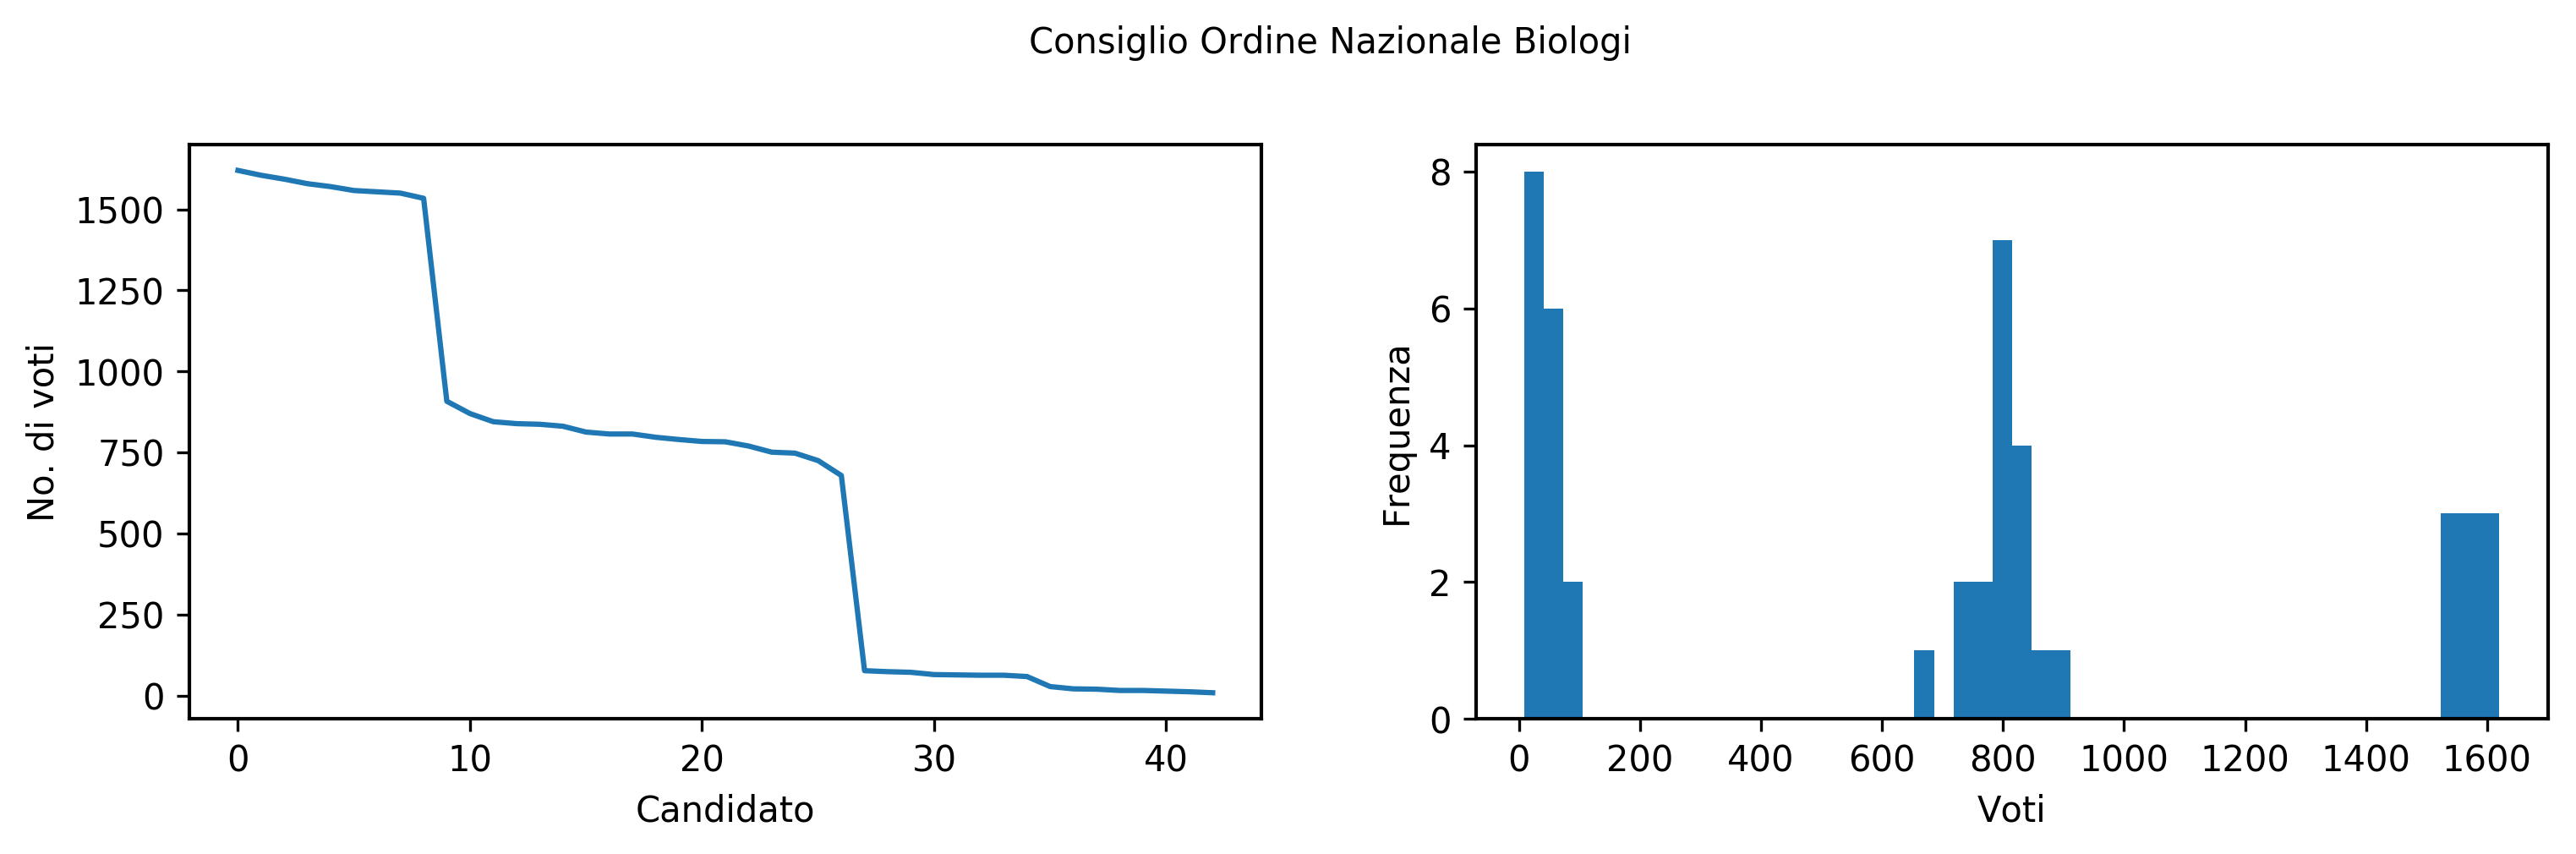

In [72]:
fig, axs = pl.subplots(1, 2, figsize=(12, 3))
axs[0].plot(onb, 'C0')
axs[0].set_xlabel("Candidato")
axs[0].set_ylabel("No. di voti")
axs[1].hist(onb, bins=50, color='C0')
axs[1].set_xlabel("Voti")
axs[1].set_ylabel("Frequenza")
fig.text(0.5, 1, 'Consiglio Ordine Nazionale Biologi', ha='center')

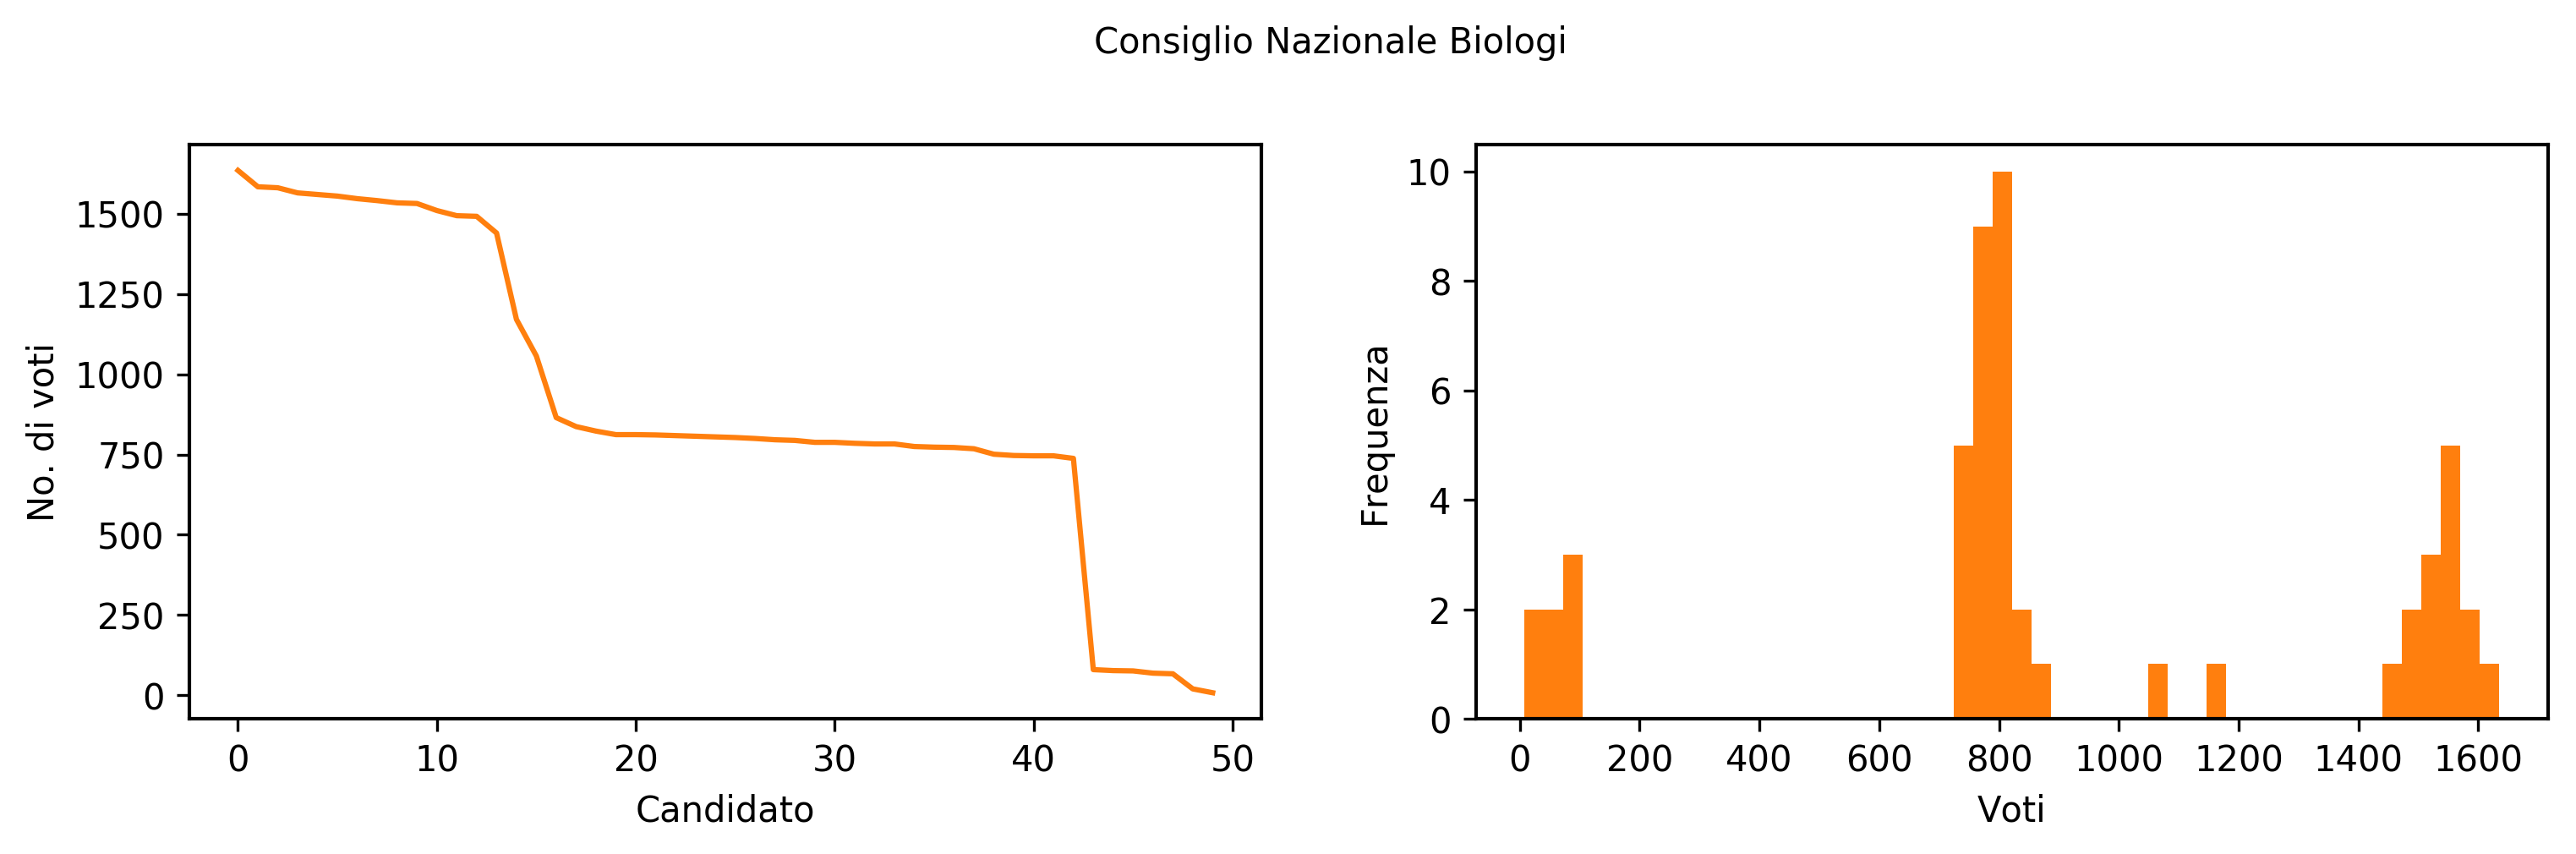

In [73]:
fig, axs = pl.subplots(1, 2, figsize=(12, 3))
axs[0].plot(cnb, 'C1')
axs[0].set_xlabel("Candidato")
axs[0].set_ylabel("No. di voti")
axs[1].hist(cnb, bins=50, color='C1')
axs[1].set_xlabel("Voti")
axs[1].set_ylabel("Frequenza")
fig.text(0.5, 1, 'Consiglio Nazionale Biologi', ha='center')

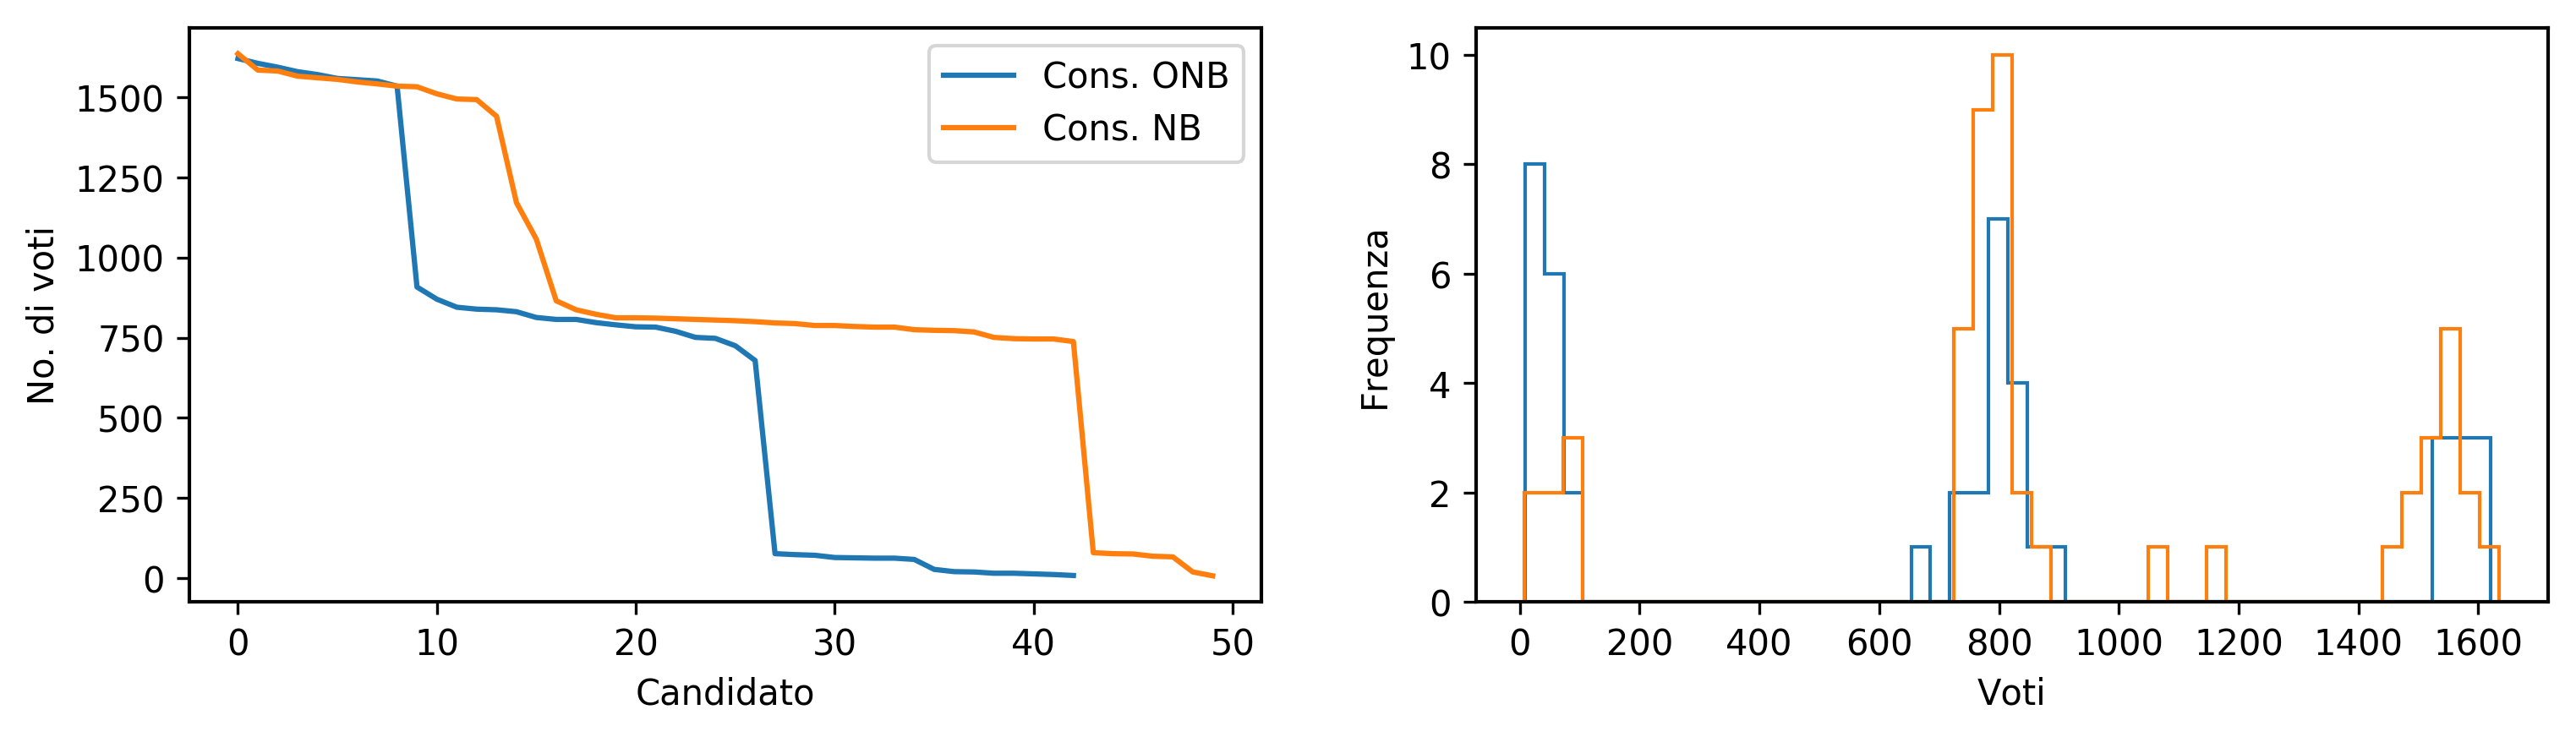

In [74]:
fig, axs = pl.subplots(1, 2, figsize=(12, 3))
axs[0].plot(onb)
axs[0].plot(cnb)
axs[0].set_xlabel("Candidato")
axs[0].set_ylabel("No. di voti")
axs[1].hist(onb, bins=50, histtype='step')
axs[1].hist(cnb, bins=50, histtype='step')
axs[1].set_xlabel("Voti")
axs[1].set_ylabel("Frequenza")
axs[0].legend(['Cons. ONB', 'Cons. NB'], fontsize=10)

In [75]:
# Preferential voting algorithm

In [76]:
# init candidate's votes
onb_rand = np.zeros(len(onb))
onb_rand[0] = 1
# for each voter
for i in range(np.sum(onb)-1):
    # select one candidate at random with a probability that depends on how many votes it got until now
    onb_rand[np.random.choice(range(len(onb)), p=(1.+onb_rand)/np.sum(1+onb_rand))] +=1
# sort votes to compare to data
onb_rand = np.sort(onb_rand)[::-1]

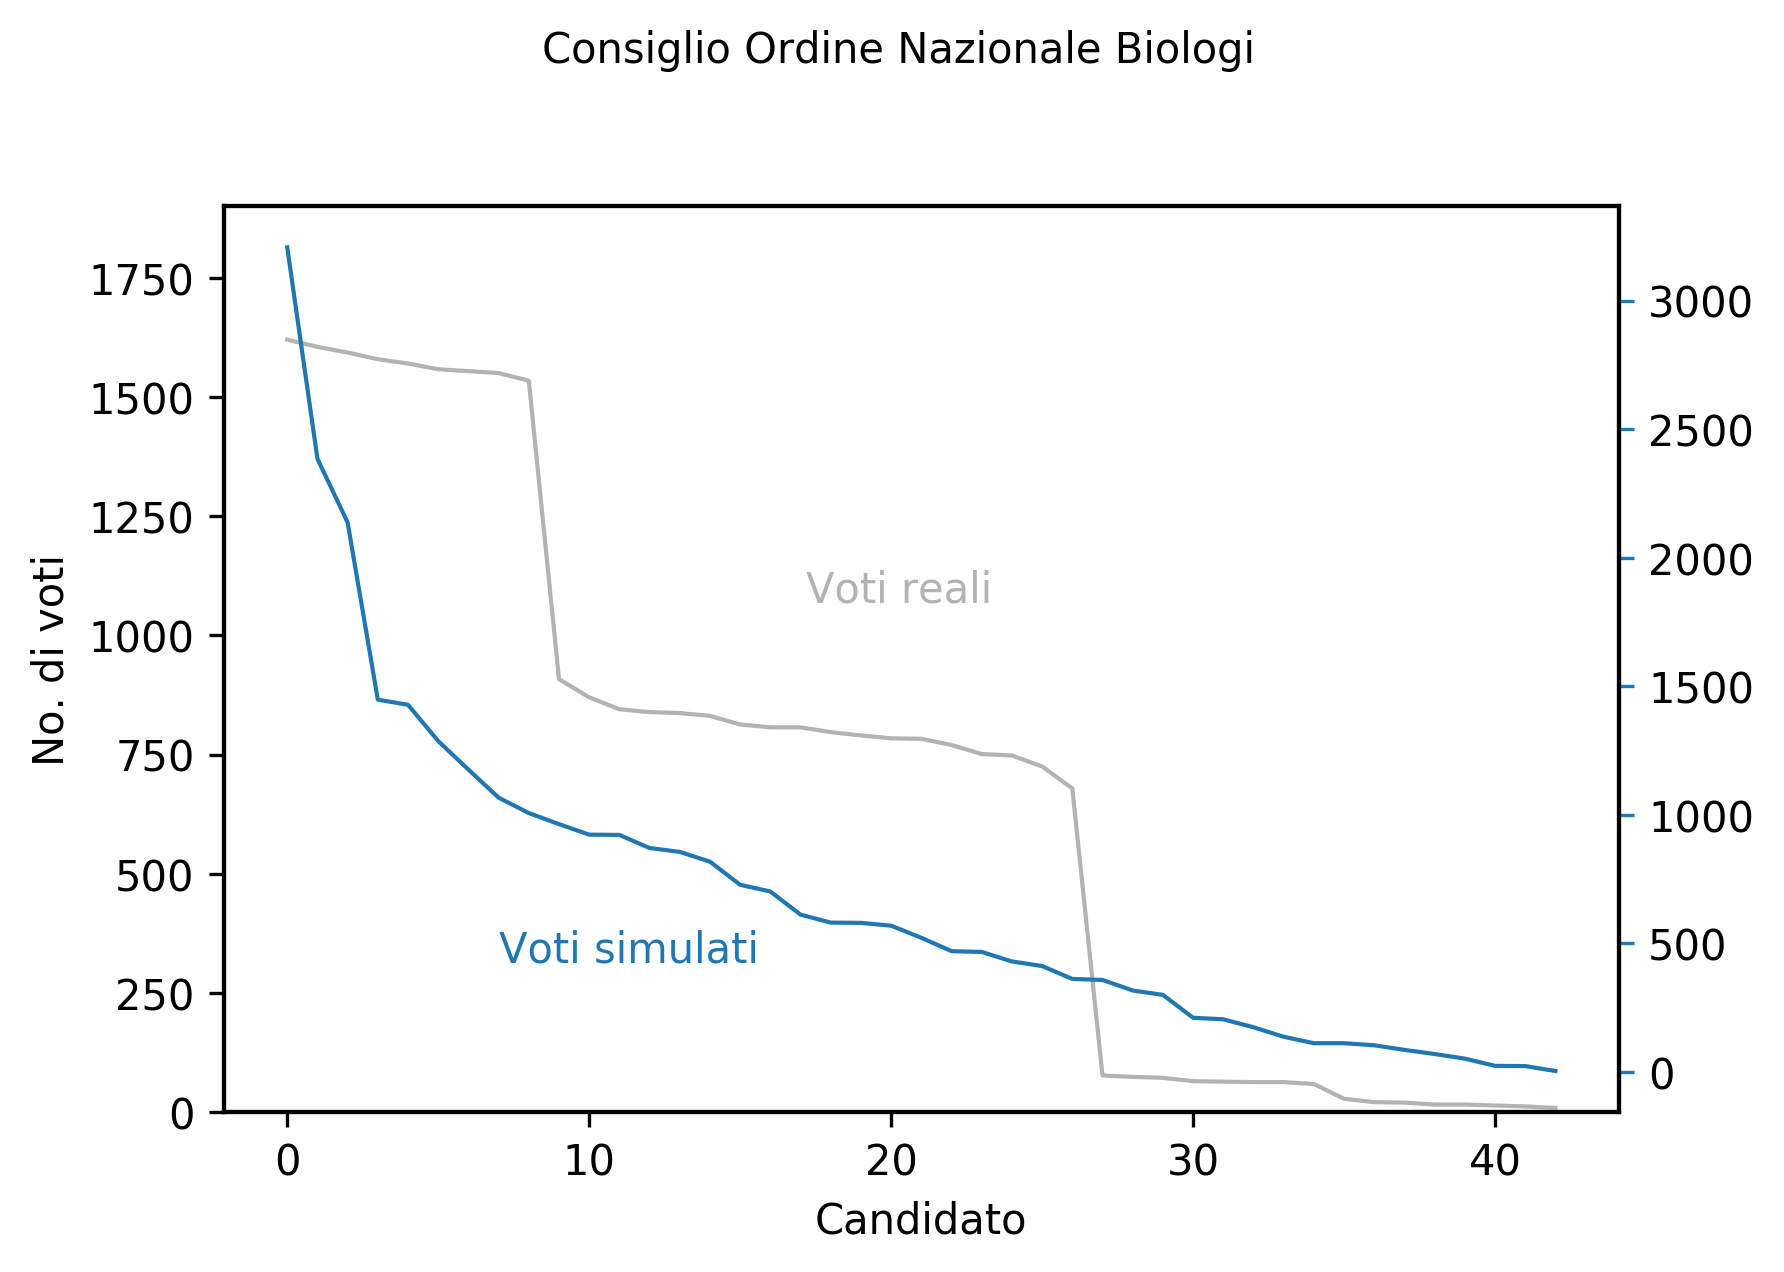

In [77]:
fig, ax = pl.subplots(1, 1, figsize=(6, 4))

ax.plot(onb, color='0.7', lw=1)
ax.set_xlabel("Candidato")
ax.set_ylabel("No. di voti")

ax1 = ax.twinx()
ax1.plot(onb_rand, color='C0', lw=1)
ax1.yaxis.set_tick_params(color='C0')
ax.set_ylim(0, 1900)

fig.text(0.35, 0.25, 'Voti simulati', ha='center', color='C0')
fig.text(0.5, 0.55, 'Voti reali', ha='center', color='0.7')

fig.text(0.5, 1, 'Consiglio Ordine Nazionale Biologi', ha='center')

## Comparison to Banford statistics

The statistics commonly known as "Benford law" states that the most significant digit in a collection of real world data follows $\log_{10}(1 + 1/d)$, where $d$ is the digit from 1 to 9.

In [78]:
# init parallel client
from ipyparallel import Client
client = Client()
dview = client[:]

In [79]:
%%px
from math import log10, floor
from scipy.constants import codata
import numpy as np

def most_significant_digit(x):
    e = floor(log10(x)) if x>0 else 0
    return int(x*10**-e)

In [56]:
dview.push(dict(onb=onb))

<AsyncResult: _push>

In [59]:
%%time
def doit(i):
    onb_rand = np.zeros(len(onb))
    onb_rand[0] = 1
    for i in range(np.sum(onb)-1):
        onb_rand[np.random.choice(range(len(onb)), p=(1.+onb_rand)/np.sum(1+onb_rand))] +=1
    onb_rand = np.sort(onb_rand)[::-1]
    
    # count how many constants have each leading digit
    count = [0]*10
    for value in onb_rand:
        x = abs(value)
        count[most_significant_digit(x)] += 1
    total = sum(count)

    # expected number of each leading digit per Benford's law
    benford = [total*log10(1 + 1./i) for i in range(1, 10)]

    return [count[1:], benford]
    
results = np.r_[dview.map_sync(doit, range(100))]

CPU times: user 267 ms, sys: 16.3 ms, total: 283 ms
Wall time: 15 s


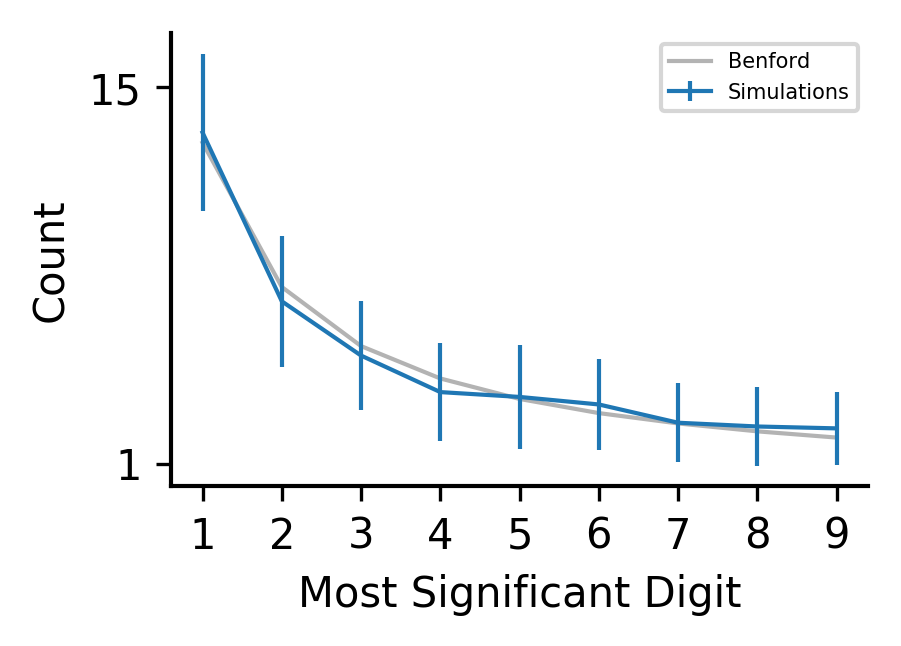

In [64]:
fig, ax = pl.subplots(1, 1, figsize=(3, 2))
ax.plot(range(1, 10), results[:, 1].mean(0), lw=1, color='0.7', zorder=0);
m, s = np.mean(results[:, 0], 0), np.std(results[:, 0], 0)
ax.errorbar(range(1, 10), m, s, lw=1)
for k in 'top', 'right':
    ax.spines[k].set_visible(False)
ax.set_xticks(range(1, 10))
ax.set_yticks([1, 15])
ax.set_xlabel('Most Significant Digit')
ax.set_ylabel('Count')
ax.legend(['Benford', 'Simulations'])

## Introducing a strong candidate

In the preferential vote algorithm, a strong candidate can be introduced by initializing it with a large number of votes. This will artificially skew the probability towards giving more votes to this candidate.

In [11]:
onb_rand = np.zeros(len(onb))
onb_rand[:9] = 100
for i in range(np.sum(onb)-np.sum(onb_rand).astype(int)):
    onb_rand[np.random.choice(range(len(onb)), p=(1.+onb_rand)/np.sum(1+onb_rand))] +=1

onb_rand = np.sort(onb_rand)[::-1]

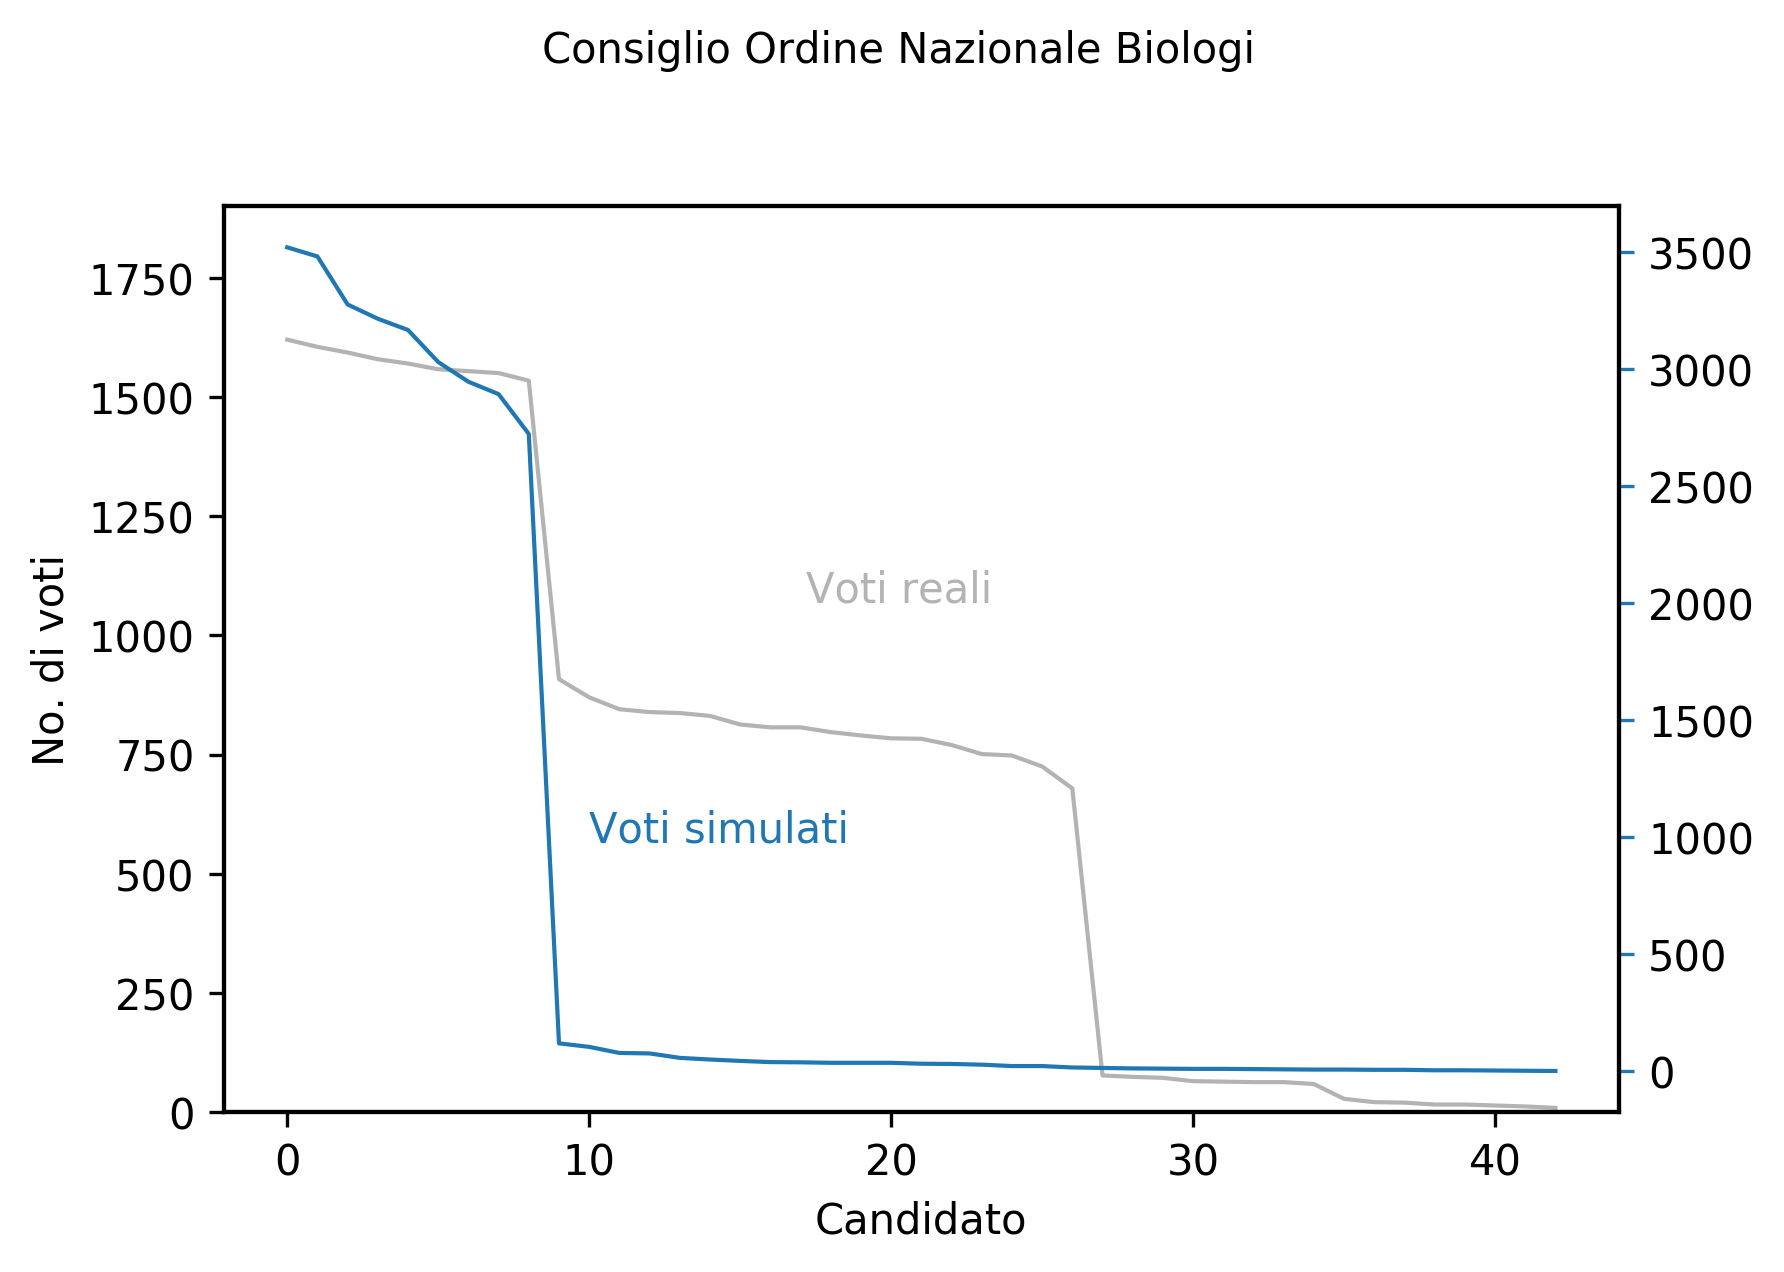

In [12]:
fig, ax = pl.subplots(1, 1, figsize=(6, 4))

ax.plot(onb, color='0.7', lw=1)
ax.set_xlabel("Candidato")
ax.set_ylabel("No. di voti")

ax1 = ax.twinx()
ax1.plot(onb_rand, color='C0', lw=1)
ax1.yaxis.set_tick_params(color='C0')
ax.set_ylim(0, 1900)

fig.text(0.4, 0.35, 'Voti simulati', ha='center', color='C0')
fig.text(0.5, 0.55, 'Voti reali', ha='center', color='0.7')

fig.text(0.5, 1, 'Consiglio Ordine Nazionale Biologi', ha='center')

In [80]:
## Introducing two strong candidates

In [13]:
onb_rand = np.zeros(len(onb))
onb_rand[:9] = 120
onb_rand[10:28] = 60
for i in range(np.sum(onb)-np.sum(onb_rand).astype(int)):
    onb_rand[np.random.choice(range(len(onb)), p=(1.+onb_rand)/np.sum(1+onb_rand))] +=1

onb_rand = np.sort(onb_rand)[::-1]

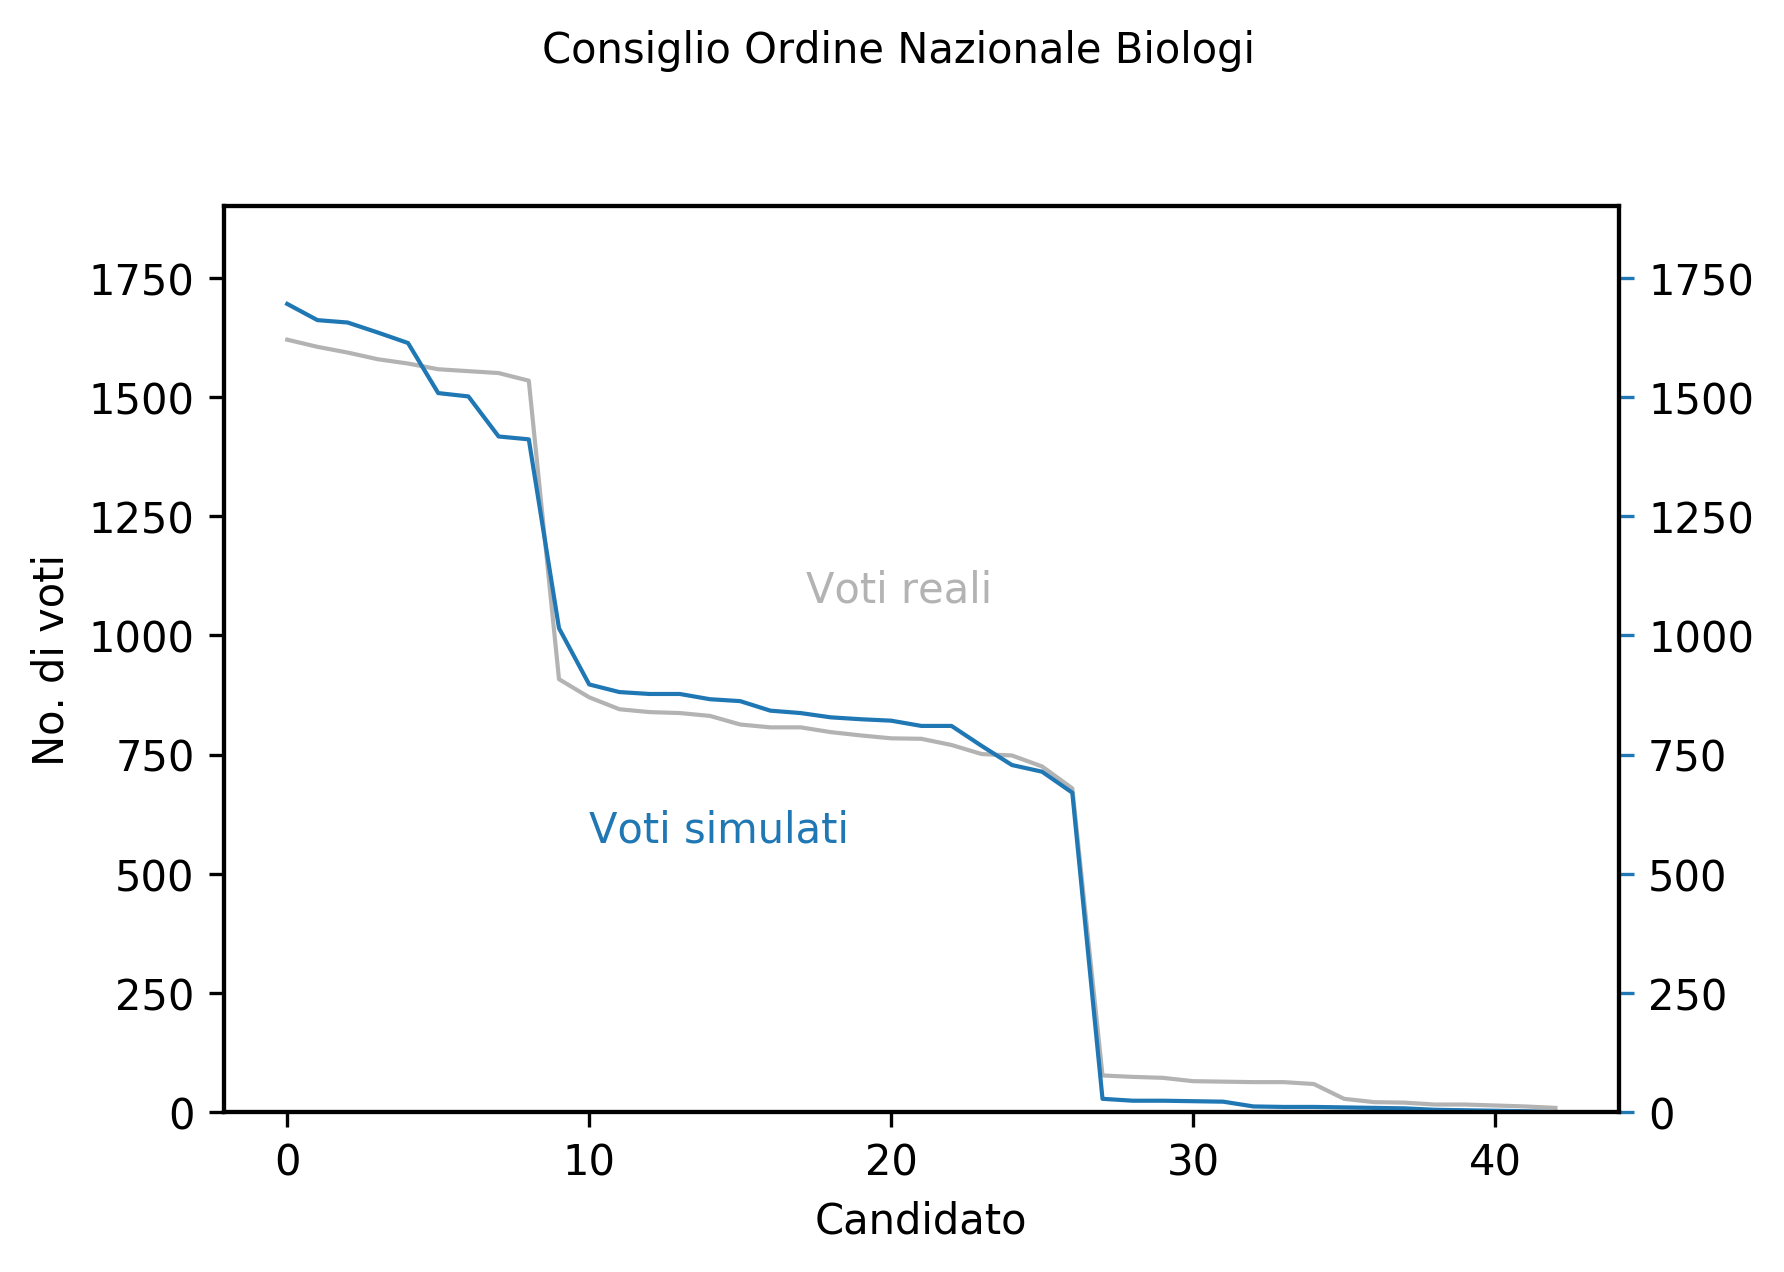

In [14]:
fig, ax = pl.subplots(1, 1, figsize=(6, 4))

ax.plot(onb, color='0.7', lw=1)
ax.set_xlabel("Candidato")
ax.set_ylabel("No. di voti")

ax1 = ax.twinx()
ax1.plot(onb_rand, color='C0', lw=1)
ax1.yaxis.set_tick_params(color='C0')
ax1.set_ylim(0, 1900)
ax.set_ylim(0, 1900)

fig.text(0.4, 0.35, 'Voti simulati', ha='center', color='C0')
fig.text(0.5, 0.55, 'Voti reali', ha='center', color='0.7')

fig.text(0.5, 1, 'Consiglio Ordine Nazionale Biologi', ha='center')

## Introducing parties or lists

In several cases, voters express preferences for entire groups of candidates, as it was the case in the ONB elections of 2017 whereby each voter could express 9 preferences total. These are unofficial lists of candidates, i.e., voters can choose to vote any candidate, however having lists strongly biases the voters decisions, especially in elections where it is unclear what are the specific personalities running for elections, as we assume it was the case in the ONB ones.

In our algorithm, we can introduce lists by grouping candidates and allowing voters to first choose a list and then express votes in that list. Lists are chosen according to the preferential votes mechanism as above, as well as votes within the list. Additionally, we allow each voter to vote a fixed number of candidates out of the chosen list.

To compare simulations to real data, we will impose the popularity of the lists by using the elections outcomes pooled across candidates of that list.

In [83]:
liste = [np.arange(9), np.arange(9, 18), np.arange(18, 27), np.arange(27, len(onb))]
voti_liste = np.r_[[45.1, 24.2, 21.8, 8.9]]

In [84]:
# n_switch = 5
onb_rands = []
for out_of_list in range(1, 9, 1):
    onb_rand = np.zeros(len(onb))
    for i in range(3589):
        # choose the list
        quale_lista = np.random.choice(range(4), p=voti_liste/np.sum(voti_liste))
        # choose candidates in list
        quali_in_lista = np.random.permutation(range(9))[:-out_of_list]
        quali = liste[quale_lista][quali_in_lista]
        # vote them
        onb_rand[quali] +=1
        # vote also the ones out of the list
        onb_rand[np.random.choice(range(len(onb)), p=(1.+onb_rand)/np.sum(1+onb_rand), size=out_of_list)] += 1

    onb_rand = np.sort(onb_rand)[::-1]
    onb_rands.append(onb_rand)

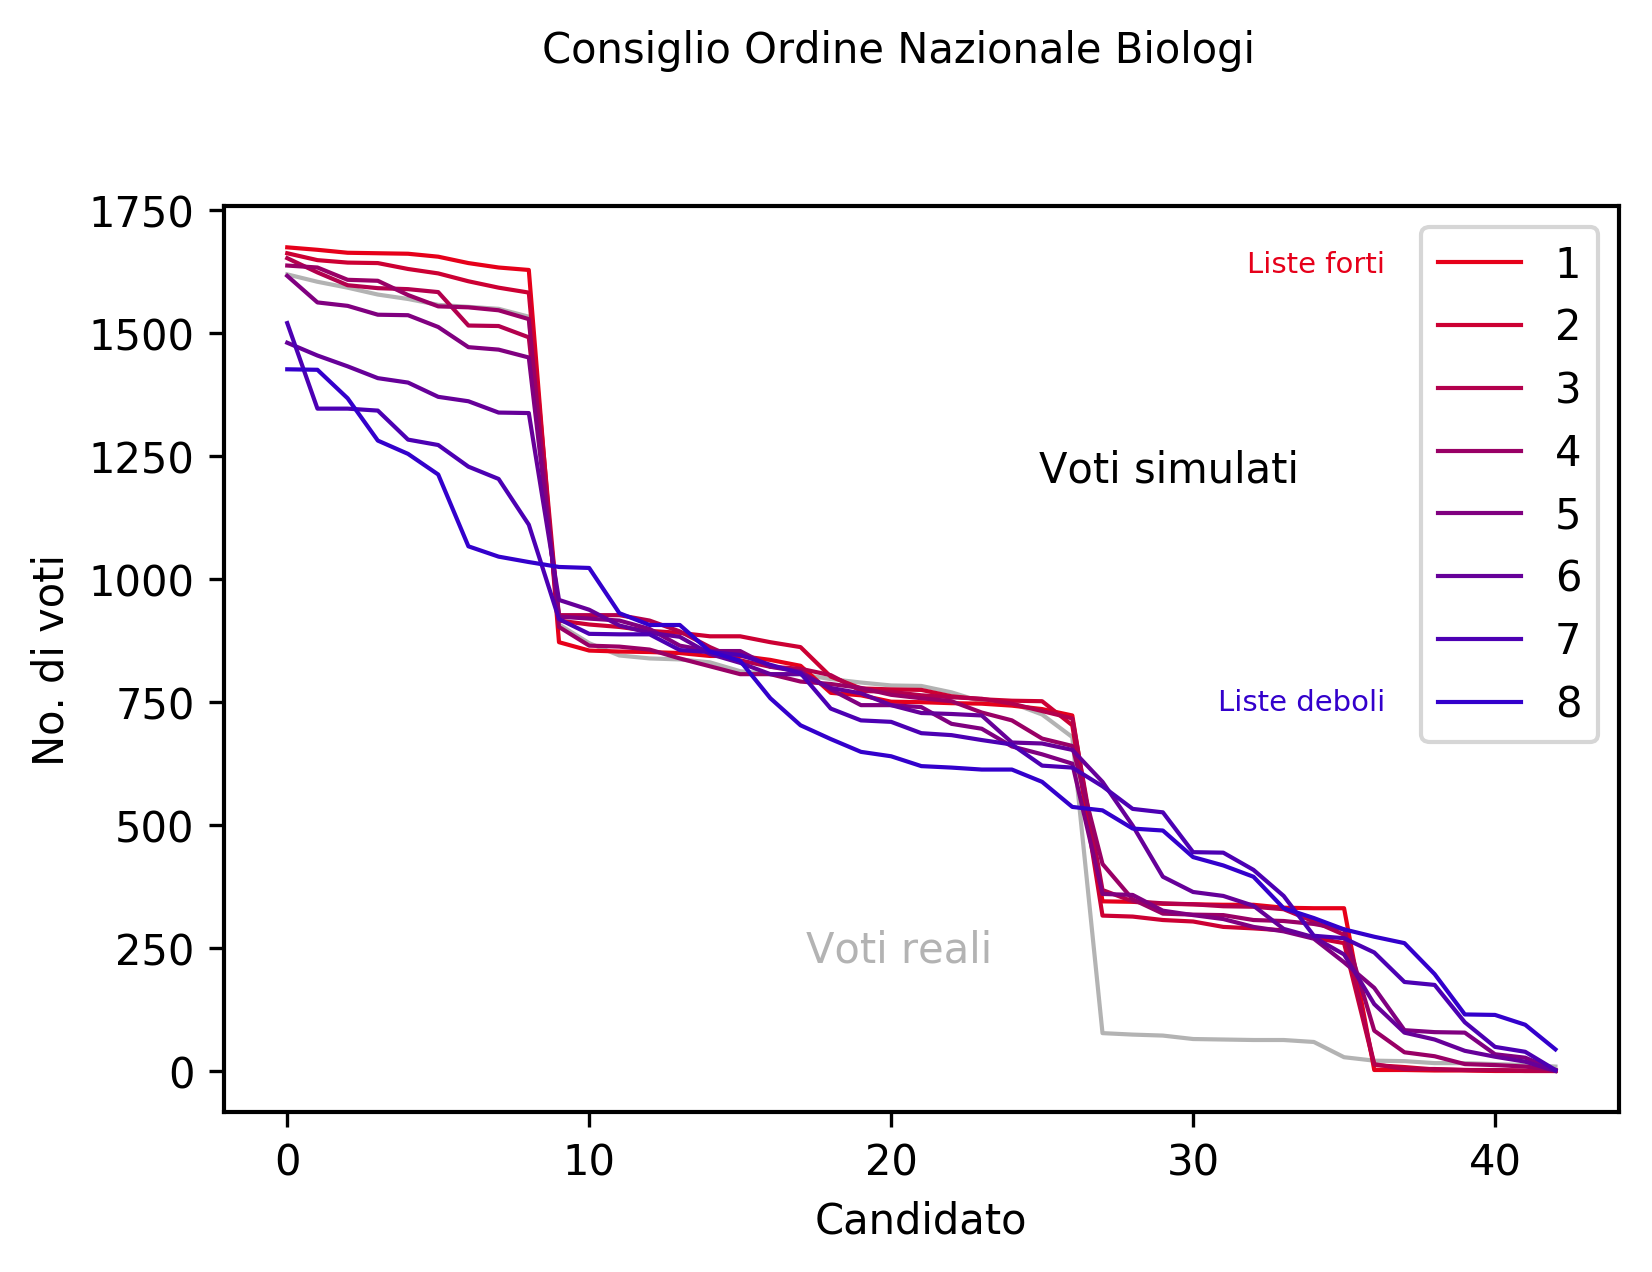

In [85]:
fig, ax = pl.subplots(1, 1, figsize=(6, 4))

ax.plot(onb, color='0.7', lw=1, label='_nolegend_')
ax.set_xlabel("Candidato")
ax.set_ylabel("No. di voti")

[ax.plot(o, color=[1-c, 0, c], lw=1) for c, o in zip(np.linspace(0.1, 0.8, len(onb_rands)), onb_rands)]

fig.text(0.65, 0.65, 'Voti simulati', ha='center', color='k')
fig.text(0.77, 0.825, 'Liste forti', ha='right', color=[0.9, 0, 0.1], fontsize=7)
fig.text(0.77, 0.46, 'Liste deboli', ha='right', color=[0.2, 0, 0.8], fontsize=7)
fig.text(0.5, 0.25, 'Voti reali', ha='center', color='0.7')
ax.legend([1, 2, 3, 4, 5, 6, 7, 8], fontsize=10)
fig.text(0.5, 1, 'Consiglio Ordine Nazionale Biologi', ha='center')

## Comparing the order of results

What is the probability that vote outcomes match the initial order? What is the probability for candidates to get more (less) votes that the ones of the one that got the least (most) number of votes in the list above (below)? How do these depend on the popularity of the candidates within the lists? How does this change if we introduce voters that don't stick to the lists at all?

In [92]:
from scipy import stats as sstats

In [93]:
# where each candidate in the printed flyers ended up in the voting outcomes
classifica_finale = np.r_[[0, 4, 1, 3, 2, 6, 7, 5, 8, 22, 10, 9, 11, 17, 12, 13,
                           14, 16, 26, 25, 24, 18, 15, 19, 20, 21, 23]][::-1]

In [91]:
np.sum(onb)/3589.

8.1415436054611305

In [142]:
n_switch = 1
# popularity within the lists
onb_rand = np.zeros(len(onb))
onb_rand[liste[0][0]] = 30  # popularity of Vincenzo d'Anna, former president
onb_rand[liste[0][1]] = 10  # popularity of the next name in the list
onb_rand[liste[1][0]] = 10  # popularity of first name in list
onb_rand[liste[1][1]] = 10  # ... second name
onb_rand[liste[2][0]] = 10  # ... first name
onb_rand[liste[2][1]] = 10  # ... second name

# probability for a voter to stick to the lists
p_list = 0.99
for i in range(3589):
    if np.random.rand()>=p_list:
        # vote as there were no lists
        onb_rand[np.random.choice(range(len(onb)), p=(1.+onb_rand)/np.sum(1+onb_rand), size=9, replace=False)] +=1
    else:
        # vote within list
        quale_lista = np.random.choice(range(len(voti_liste)), p=voti_liste/np.sum(voti_liste))
        quali_in_lista = np.random.permutation(range(9))[:(-n_switch if n_switch>0 else None)]
        quali = liste[quale_lista][quali_in_lista]
        onb_rand[quali] +=1
        ilresto = np.delete(range(len(onb)), quali)
        onb_rand[np.random.choice(ilresto, p=(1.+onb_rand[ilresto])/np.sum(1+onb_rand[ilresto]), size=n_switch, replace=False)] += 1

# onb_rand = np.sort(onb_rand)[::-1]

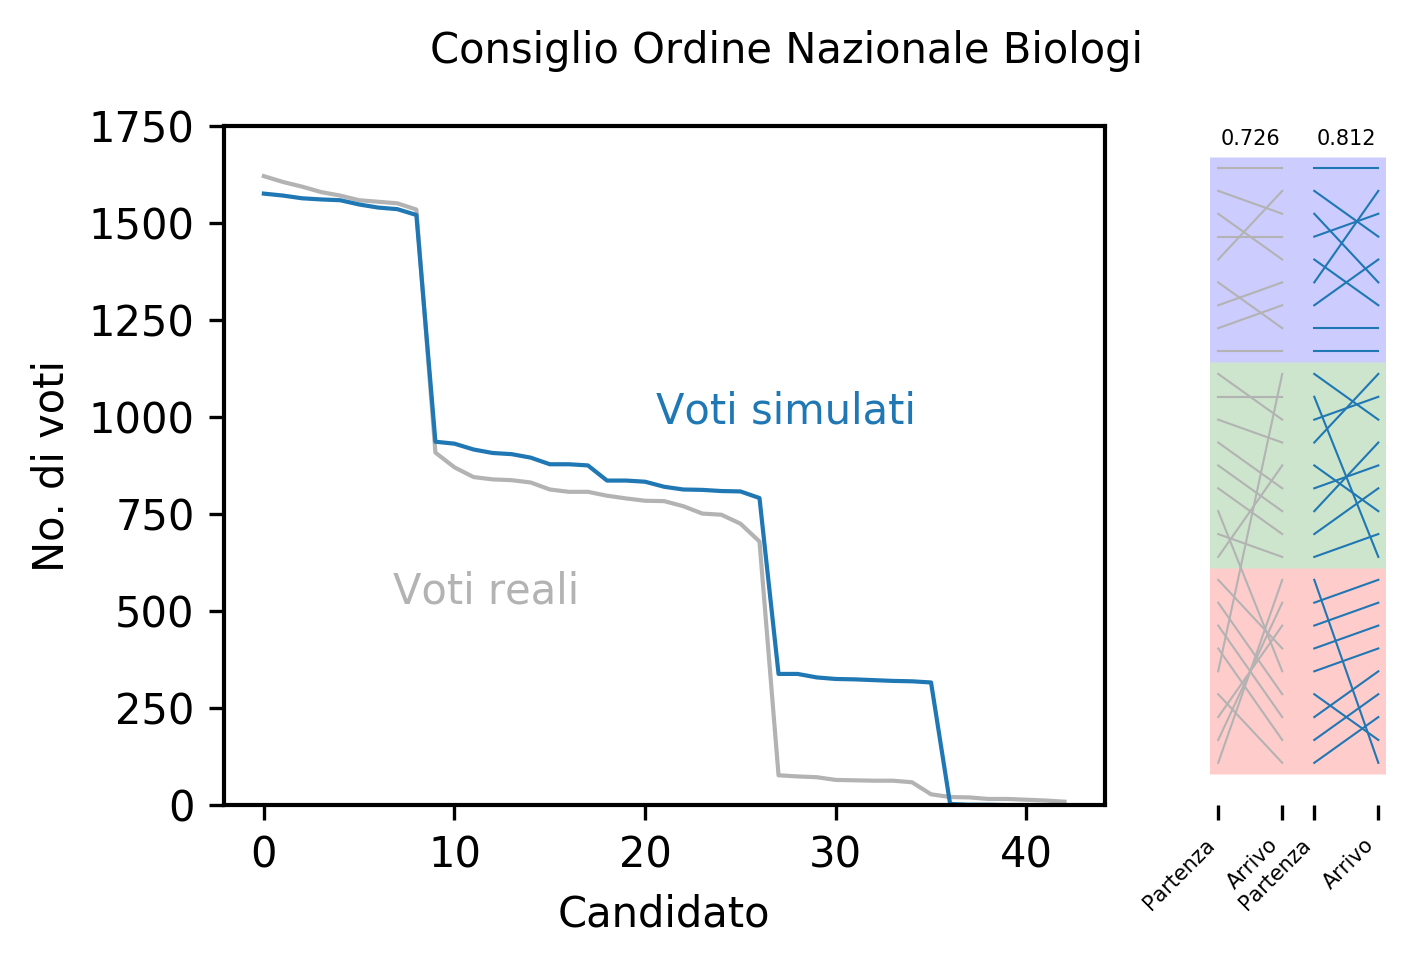

In [143]:
fig, axs = pl.subplots(1, 2, figsize=(5, 3), gridspec_kw={'width_ratios':[5, 1]})
ax = axs[1]
for i, o in zip(range(26, -1, -1), np.argsort(onb_rand)[::-1]):
    ax.plot([2, 1.2], [26-o, i], '-', color='C0', lw=0.5)
for i, o in zip(range(26, -1, -1), np.argsort(classifica_finale)):
    ax.plot([0.8, 0], [o, i], '-', color='0.7', lw=0.5)

ax.vlines(1, 0-0.5, 9-0.5, color='r', lw=100, alpha=0.2, zorder=0)
ax.vlines(1, 9-0.5, 18-0.5, color='g', lw=100, alpha=0.2, zorder=0)
ax.vlines(1, 18-0.5, 27-0.5, color='b', lw=100, alpha=0.2, zorder=0)
for s in ax.spines.values():
    s.set_visible(False)
ax.set_yticks(())
ax.set_xticks((0, 0.8, 1.2, 2))
ax.set_xticklabels(['Partenza', 'Arrivo']*2, fontsize=5, ha='right', rotation=45)
ax.set_xlim(-0.1, 2.1)
# ax.set_ylim(28, -0.5)

k1 = sstats.kendalltau(classifica_finale[::-1], range(len(classifica_finale)))[0]
k2 = sstats.kendalltau(np.argsort(onb_rand)[::-1][:27], range(len(classifica_finale)))[0]

ax.text(0.4, 27, "%.3lf"%k1, ha='center', fontsize=5)
ax.text(1.6, 27, "%.3lf"%k2, ha='center', fontsize=5)

# fig, ax = pl.subplots(1, 1, figsize=(6, 4))
ax = axs[0]

ax.plot(onb, color='0.7', lw=1)
ax.set_xlabel("Candidato")
ax.set_ylabel("No. di voti")

ax.plot(np.sort(onb_rand)[::-1], color='C0', lw=1)

ax.set_ylim(0, 1750)

fig.text(0.5, 0.55, 'Voti simulati', ha='center', color='C0')
fig.text(0.3, 0.35, 'Voti reali', ha='center', color='0.7')

fig.text(0.5, 0.95, 'Consiglio Ordine Nazionale Biologi', ha='center', fontsize=10)

## Updating list popularities

In [96]:
n_switch = 1
# voti_liste = np.r_[[45.1, 24.2, 21.8, 8.9]]
voti_liste = np.r_[[50., 20, 20, 20]]
onb_rand = np.zeros(len(onb))
# onb_rand[liste[0][0]] = 20
# onb_rand[liste[0][1]] = 10
# onb_rand[liste[1][0]] = 16
# onb_rand[liste[1][1]] = 8
# onb_rand[liste[2][0]] = 16
# onb_rand[liste[2][1]] = 8

p_elettore_ribelle = 0.0
for i in range(3589):
    if np.random.rand()<p_elettore_ribelle:
        onb_rand[np.random.choice(range(len(onb)), p=(1.+onb_rand)/np.sum(1+onb_rand), size=9, replace=False)] +=1
    else:
        quale_lista = np.random.choice(range(4), p=voti_liste/np.sum(voti_liste))
        voti_liste[quale_lista] += 1
        quali_in_lista = np.random.permutation(range(9))[:(-n_switch if n_switch>0 else None)]
        quali = liste[quale_lista][quali_in_lista]
        onb_rand[quali] +=1
        ilresto = np.delete(range(len(onb)), quali)
        onb_rand[np.random.choice(ilresto, p=(1.+onb_rand[ilresto])/np.sum(1+onb_rand[ilresto]), size=n_switch, replace=False)] += 1

# onb_rand = np.sort(onb_rand)[::-1]

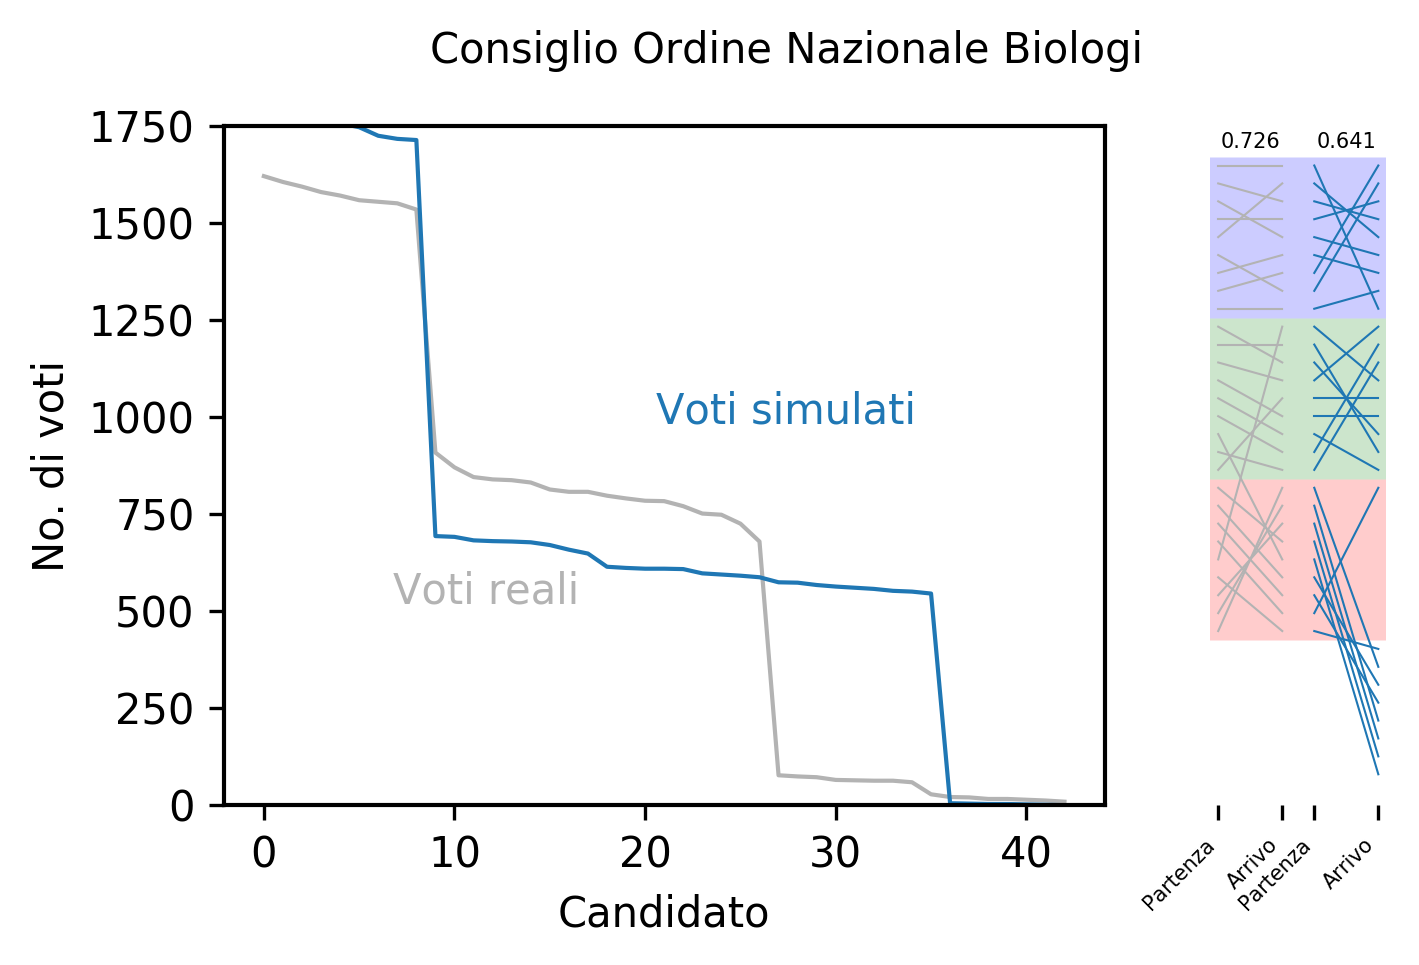

In [97]:
fig, axs = pl.subplots(1, 2, figsize=(5, 3), gridspec_kw={'width_ratios':[5, 1]})
ax = axs[1]
for i, o in zip(range(26, -1, -1), np.argsort(onb_rand)[::-1]):
    ax.plot([2, 1.2], [26-o, i], '-', color='C0', lw=0.5)
for i, o in zip(range(26, -1, -1), np.argsort(classifica_finale)):
    ax.plot([0.8, 0], [o, i], '-', color='0.7', lw=0.5)

ax.vlines(1, 0-0.5, 9-0.5, color='r', lw=100, alpha=0.2, zorder=0)
ax.vlines(1, 9-0.5, 18-0.5, color='g', lw=100, alpha=0.2, zorder=0)
ax.vlines(1, 18-0.5, 27-0.5, color='b', lw=100, alpha=0.2, zorder=0)
for s in ax.spines.values():
    s.set_visible(False)
ax.set_yticks(())
ax.set_xticks((0, 0.8, 1.2, 2))
ax.set_xticklabels(['Partenza', 'Arrivo']*2, fontsize=5, ha='right', rotation=45)
ax.set_xlim(-0.1, 2.1)
# ax.set_ylim(28, -0.5)

k1 = sstats.kendalltau(classifica_finale[::-1], range(len(classifica_finale)))[0]
k2 = sstats.kendalltau(np.argsort(onb_rand)[::-1][:27], range(len(classifica_finale)))[0]

ax.text(0.4, 27, "%.3lf"%k1, ha='center', fontsize=5)
ax.text(1.6, 27, "%.3lf"%k2, ha='center', fontsize=5)

# fig, ax = pl.subplots(1, 1, figsize=(6, 4))
ax = axs[0]

ax.plot(onb, color='0.7', lw=1)
ax.set_xlabel("Candidato")
ax.set_ylabel("No. di voti")

ax.plot(np.sort(onb_rand)[::-1], color='C0', lw=1)

ax.set_ylim(0, 1750)

fig.text(0.5, 0.55, 'Voti simulati', ha='center', color='C0')
fig.text(0.3, 0.35, 'Voti reali', ha='center', color='0.7')

fig.text(0.5, 0.95, 'Consiglio Ordine Nazionale Biologi', ha='center', fontsize=10)